## 0. 메모
- task
    - 일단 군집화는 완료.
        - 군집별 분석 수행
        - 변수별 중요도 파악
            - feature importance in segmentation (혹은 모델링 별도 수행하거나. 피쳐 중요도는 꼭)
        - 방법도 다시 고민해보기 시간되면.. kmeans말고 그 밀도기반이나..
    - 은혜 데이터 변경필요.
    - 근거들을 통한 생성형 ai (추천문구)
    - 동기님 전달 (인풋, 아웃풋)
    - 이후 추가소요 회의 (게시판 참고)
- 주제
    - 내점하는 손님에게 추천상품(퇴직연금 제안이 가능할지)과 추천문구를 알려주는 계정계 화면을 통해 출력해주는 프로세스 개발.
    - 영업 피로도를 낮추고 실적 향상 기대.
        - 퇴직 연금이 이러한 경향이 제일 강했다 (텔러의 경험에 의존, 근거없는 영업)
    - 추천문구 : 생성형 ai
    - 현재상품과 비교해서 (제안을 받아들였을 시) 손님이 얻을 수 있는 이익을 수치화/시각화
        - 기존과 별개로 etf, irp, isa 등으로 구성된 포트폴리오 제안.

- 원래 데이터는 텔러 마케팅에 대한 기록임. 즉 영업활동이 전화활동 뿐이고 이것에 대한 기록이 경과시간(초), 횟수로 나타나게 됨.
    - crdeit in default : 신용불량?
    - housing : 주택담보대출
    - compaign : 이 캠패인 기간동안 연락 한 수
        - 최근 권유 횟수 (대면, 전화, lms 등)
    - duration : 마지막 연락의 duration (초)
        - 가장 최근 권유의 duration
    - pdays : 이전 캠패인에서 마지막 연락 후 며칠이 경과했는지 일 수
        - 마지막 권유로부터 며칠이 경과했는가
    - previous : 이 캠패인 전에 몇번 연락을 했는가
        - 이전 권유 횟수
    - poutcome : 이전 마케팅의 성과 (성공, 실패, 모름 등)
        - 이전 권유에 대한 결과

In [200]:
pip install chart-studio

In [201]:
pip install squarify

In [202]:
from chart_studio import plotly
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go

## 1. 데이터 분포 파악

In [203]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [204]:
data_path = '/content/drive/MyDrive/Colab Notebooks/KB_AI/data/'
df = pd.read_csv(data_path +'pension_dataset.csv')
print(len(df))
df = df.iloc[:,1:]
df.head()

11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pension
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,0
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,0
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,0


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  pension    11162 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 1.4+ MB


pension 0이면 no 1이면 yes

In [206]:
def change_pension(x):
    if x == 0 :
        x = 'no'
    else :
        x = 'yes'
    return x

def change_contact(x):
    if x == 'cellular' :
        x = 'App'
    elif x == 'unknown' :
        x = 'branch'
    else :
        x = 'call center'
    return x

def change_poutcome(x):
    if x == 'other':
        x = 'leave'
    return x

# apply할때는 def에서 return을 꼭 써줘야함!

In [207]:
df['pension'] = df['pension'].apply(change_pension)
df['contact'] = df['contact'].apply(change_contact)
df['poutcome'] = df['poutcome'].apply(change_poutcome)

In [208]:
# 퇴직연금 가입 대상이 안되는 (직업분류 kosis에 없는) 직업은 삭제
drop_cols = ['retired', 'unemployed', 'housemaid', 'unknown', 'student']
for drop_col in drop_cols :
    df = df.drop(df.loc[df["job"] == drop_col].index)

# admin, management 통일
lst = [df]
for col in lst:
    col.loc[col["job"] == "admin.", "job"] = "management"

print(len(df))
df.head()

9323


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pension
0,59,management,married,secondary,no,2343,yes,no,branch,5,may,1042,1,-1,0,unknown,no
1,56,management,married,secondary,no,45,no,no,branch,5,may,1467,1,-1,0,unknown,no
2,41,technician,married,secondary,no,1270,yes,no,branch,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,branch,5,may,579,1,-1,0,unknown,no
4,54,management,married,tertiary,no,184,no,no,branch,5,may,673,2,-1,0,unknown,no


In [209]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pension
0,59,management,married,secondary,no,2343,yes,no,branch,5,may,1042,1,-1,0,unknown,no
1,56,management,married,secondary,no,45,no,no,branch,5,may,1467,1,-1,0,unknown,no
2,41,technician,married,secondary,no,1270,yes,no,branch,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,branch,5,may,579,1,-1,0,unknown,no
4,54,management,married,tertiary,no,184,no,no,branch,5,may,673,2,-1,0,unknown,no


In [210]:
print(df.duplicated().sum(),'\n') # 중복된 데이터 있는지
print(df.isna().sum()) # 결측치 있는지

0 

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
pension      0
dtype: int64


In [211]:
# 수치형, 범주형 변수 분류
con_feat = []
cate_feat = []

for col in df.columns :
    if df[col].dtype == object :
        print(df[col].value_counts(),'\n')
        cate_feat.append(col)
    else :
        con_feat.append(col)

management       3900
blue-collar      1944
technician       1823
services          923
self-employed     405
entrepreneur      328
Name: job, dtype: int64 

married     5330
single      2968
divorced    1025
Name: marital, dtype: int64 

secondary    4670
tertiary     3330
primary       995
unknown       328
Name: education, dtype: int64 

no     9178
yes     145
Name: default, dtype: int64 

yes    4916
no     4407
Name: housing, dtype: int64 

no     7962
yes    1361
Name: loan, dtype: int64 

App            6704
branch         2112
call center     507
Name: contact, dtype: int64 

may    2575
jul    1280
aug    1257
jun    1021
nov     810
apr     770
feb     587
oct     275
jan     255
sep     224
mar     198
dec      71
Name: month, dtype: int64 

unknown    7043
failure    1048
success     785
leave       447
Name: poutcome, dtype: int64 

no     7230
yes    2093
Name: pension, dtype: int64 



## 범주형 변수 처리

In [212]:
print(df[cate_feat].nunique()) # df[col].unique() 여러개 개수 파악하는 경우 리스트 받아서 nunique() 가능

job           6
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
pension       2
dtype: int64


In [214]:
def draw_cate_feat(size, height, width, subplot_cols, target_col, df) :
    plt.figure(figsize = size)
    for elem, col in enumerate(subplot_cols):
        plt.subplot(height, width, elem+1)
        if col != target_col:
            sns.countplot(x = col, hue = target_col, data=df, edgecolor = 'black')
            plt.title(f'countplot of <{col}> by {target_col}')
        else :
            sns.countplot(x = col, data=df, edgecolor = 'black')
            plt.title(f'countplot of <{col}>')
    plt.tight_layout()
    plt.show()



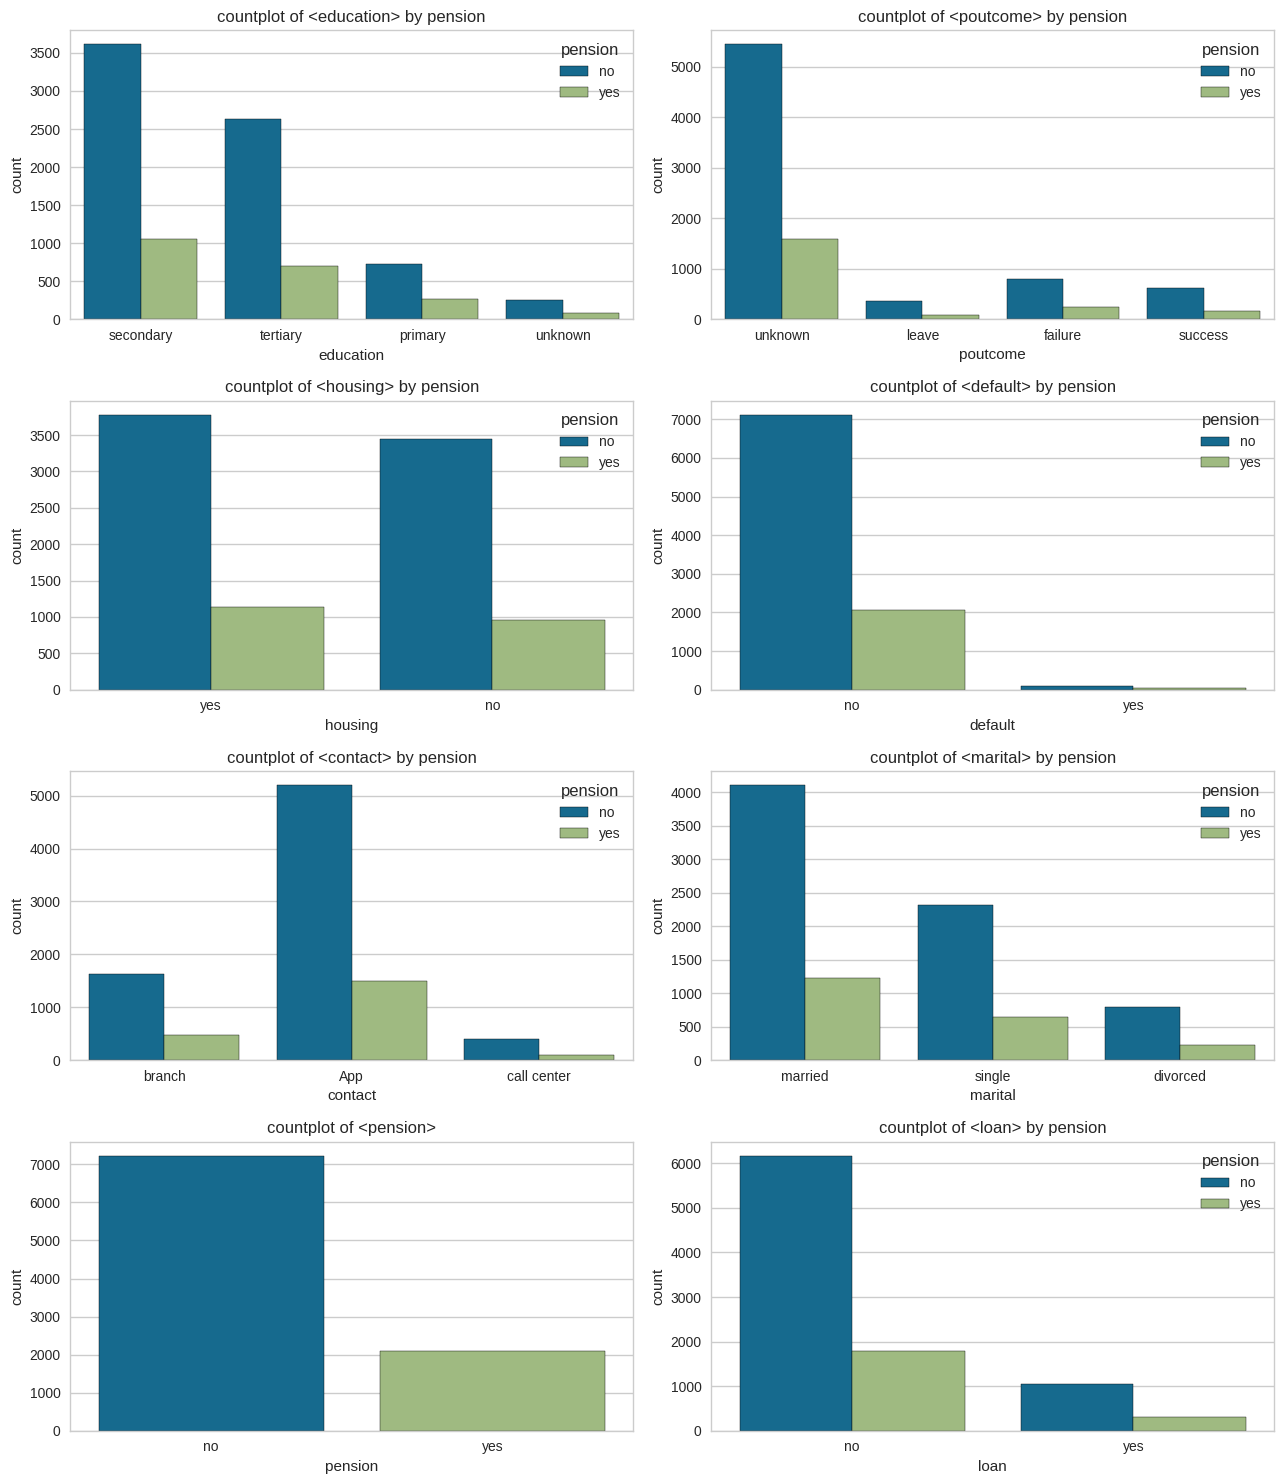

In [215]:
# subplot으로 볼거 8개, 따로 볼거 2개
size = (13, 15)
height = 4
width = 2
target_col = 'pension'
other_cols = ['job', 'month']
subplot_cols = list(set(df[cate_feat]) - set(other_cols)) # list는 차집합이 안됨

draw_cate_feat(size, height, width, subplot_cols, target_col, df)

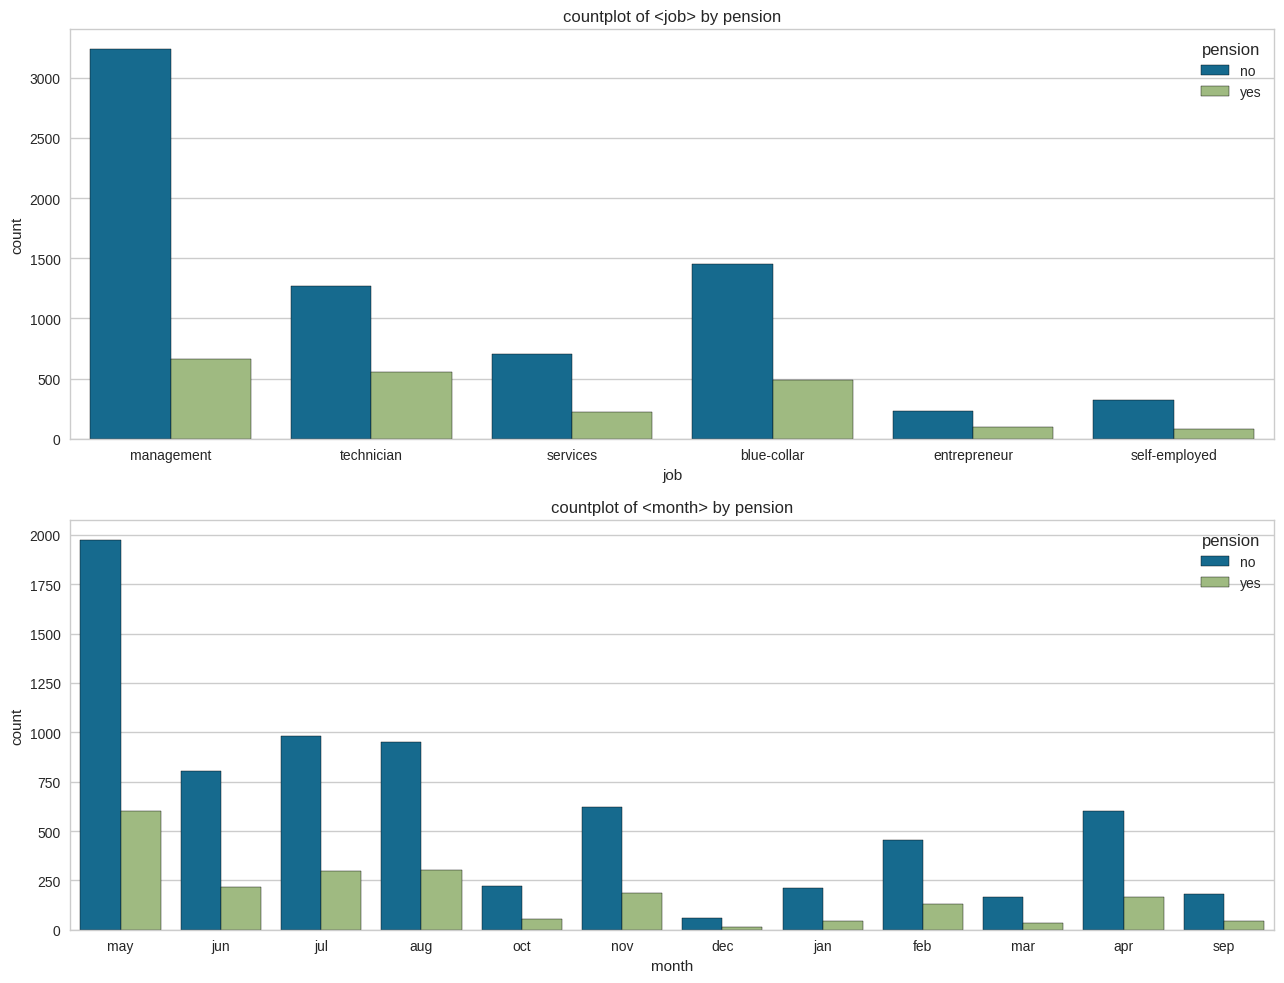

In [216]:
size = (13, 10)
height = 2
width = 1
target_col = 'pension'
subplot_cols = other_cols

draw_cate_feat(size, height, width, subplot_cols, target_col, df)

In [217]:
fig=px.pie(df.contact.value_counts().reset_index().rename(columns={'index':'Contact','contact':'Count'}),names='Contact',values='Count',hole=0.5,template='simple_white')
fig.update_traces(marker=dict(line=dict(color='#000000', width=1.4)))
fig.update_layout(title_x=0.5,showlegend=True,legend_title_text='<b>Contact')
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_x=0.5,legend=dict(orientation='h',yanchor='bottom',y=1.02,xanchor='right',x=1))
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임


fig=px.pie(df.poutcome.value_counts().reset_index().rename(columns={'index':'Poutcome','poutcome':'Count'}),names='Poutcome',values='Count',hole=0.5,template='simple_white',color_discrete_sequence=['grey','red','blue','green'])
fig.update_traces(marker=dict(line=dict(color='#000000', width=1.4)))
fig.update_layout(title_x=0.5,showlegend=True,legend_title_text='<b>Poutcome')
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_x=0.5,title_text='<b>Outcome of previous marketing Campaign',font_family="Times New Roman",title_font_family="Times New Roman")
fig.update_layout(title_x=0.5,legend=dict(orientation='v',yanchor='middle',y=1.02,xanchor='right',x=1))
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

In [218]:
a=df.groupby(['job','pension'],as_index=False)['age'].count().rename(columns={'age':'Count'})
a['percent']=round(a['Count']*100/a.groupby('job')['Count'].transform('sum'),1)
a['percent']=a['percent'].apply(lambda x: '{}%'.format(x))
fig=px.bar(a,x='job',y='Count',text='percent',color='pension',barmode='group',template='simple_white',color_discrete_sequence=['MediumPurple','YellowGreen'])
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)),textposition = "outside")
fig.update_layout(title_x=0.5,template='simple_white',showlegend=True,title_text='<b style="color:black; font-size:105%;">Pension based on Job Type</b>',font_family="Times New Roman",title_font_family="Times New Roman")
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

In [219]:
fig=px.treemap(df.groupby(['job','pension'],as_index=False)['age'].count().rename(columns={'age':'Count'}),path=['job','pension','Count'],template='simple_white')
fig.update_layout(title_x=0.5,template='simple_white',title_text='<b style="color:black; font-size:100%;">Treemap on count of clients who subscribed the Pension or not based on Job',font_family="Times New Roman",title_font_family="Times New Roman")
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

## 수치형 변수 처리

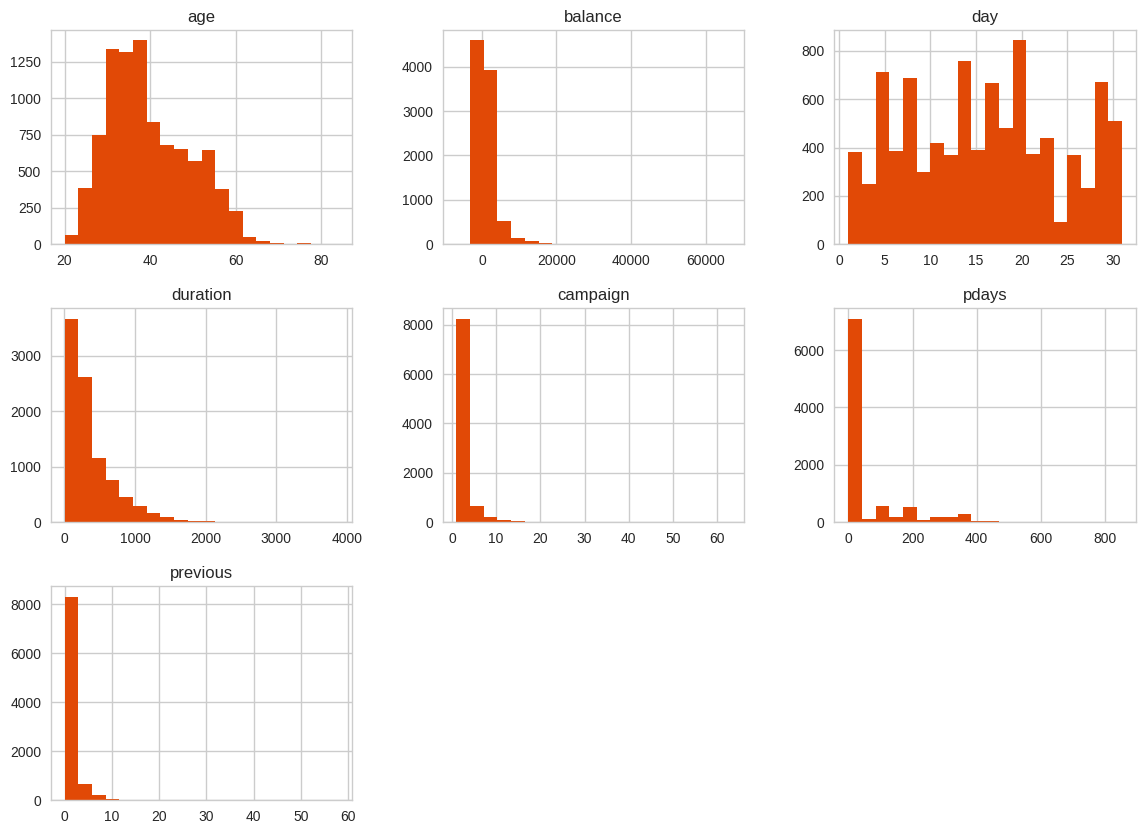

In [220]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

In [221]:
fig=px.line(df.groupby(['age','pension'],as_index=False)['job'].count().rename(columns={'job':'Count'}),x='age',y='Count',color='pension',template='simple_white',color_discrete_sequence=['DarkBlue','ForestGreen'])
fig.update_layout(title_x=0.08,font_family="Times New Roman",legend_title_text="<b> pension",title_text='<b style="font-family: Times New Roman; font-size:1.3vw">Effect of Age on  pensions')
fig.add_annotation(
  x=55,  # arrows' head
  y=165,  # arrows' head
  ax=60,  # arrows' tail
  ay=200,  # arrows' tail
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='Even <b style="color: Brown;">mid-age group</b> clients <b style="color: green;">subscribed</b> more for the  pensions,<br>     there is a more domination of clients from this group who are <br><b style="color: red;">not subscribed</b> for the <b style="color: Indigo;"> pensions</b>.',  # if you want only the arrow
  showarrow=True,
  arrowhead=3,
  arrowsize=1,
  arrowwidth=1,
  arrowcolor='black'
)
fig.add_annotation(
  x=75,  # arrows' head
  y=30,  # arrows' head
  ax=80,  # arrows' tail
  ay=65,  # arrows' tail
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='<b style="color: Brown;">old age group</b> clients are <b style="color: Green;">subscribing</b> the <b style="color: Indigo;"> pensions</b> more<br> and count of <b style="color: red;">not subscribing</b> to the pensions is <b style="color: Green;">less</b>.',  # if you want only the arrow
  showarrow=True,
  arrowhead=3,
  arrowsize=1,
  arrowwidth=1,
  arrowcolor='black'
)
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

### 이상치 제거

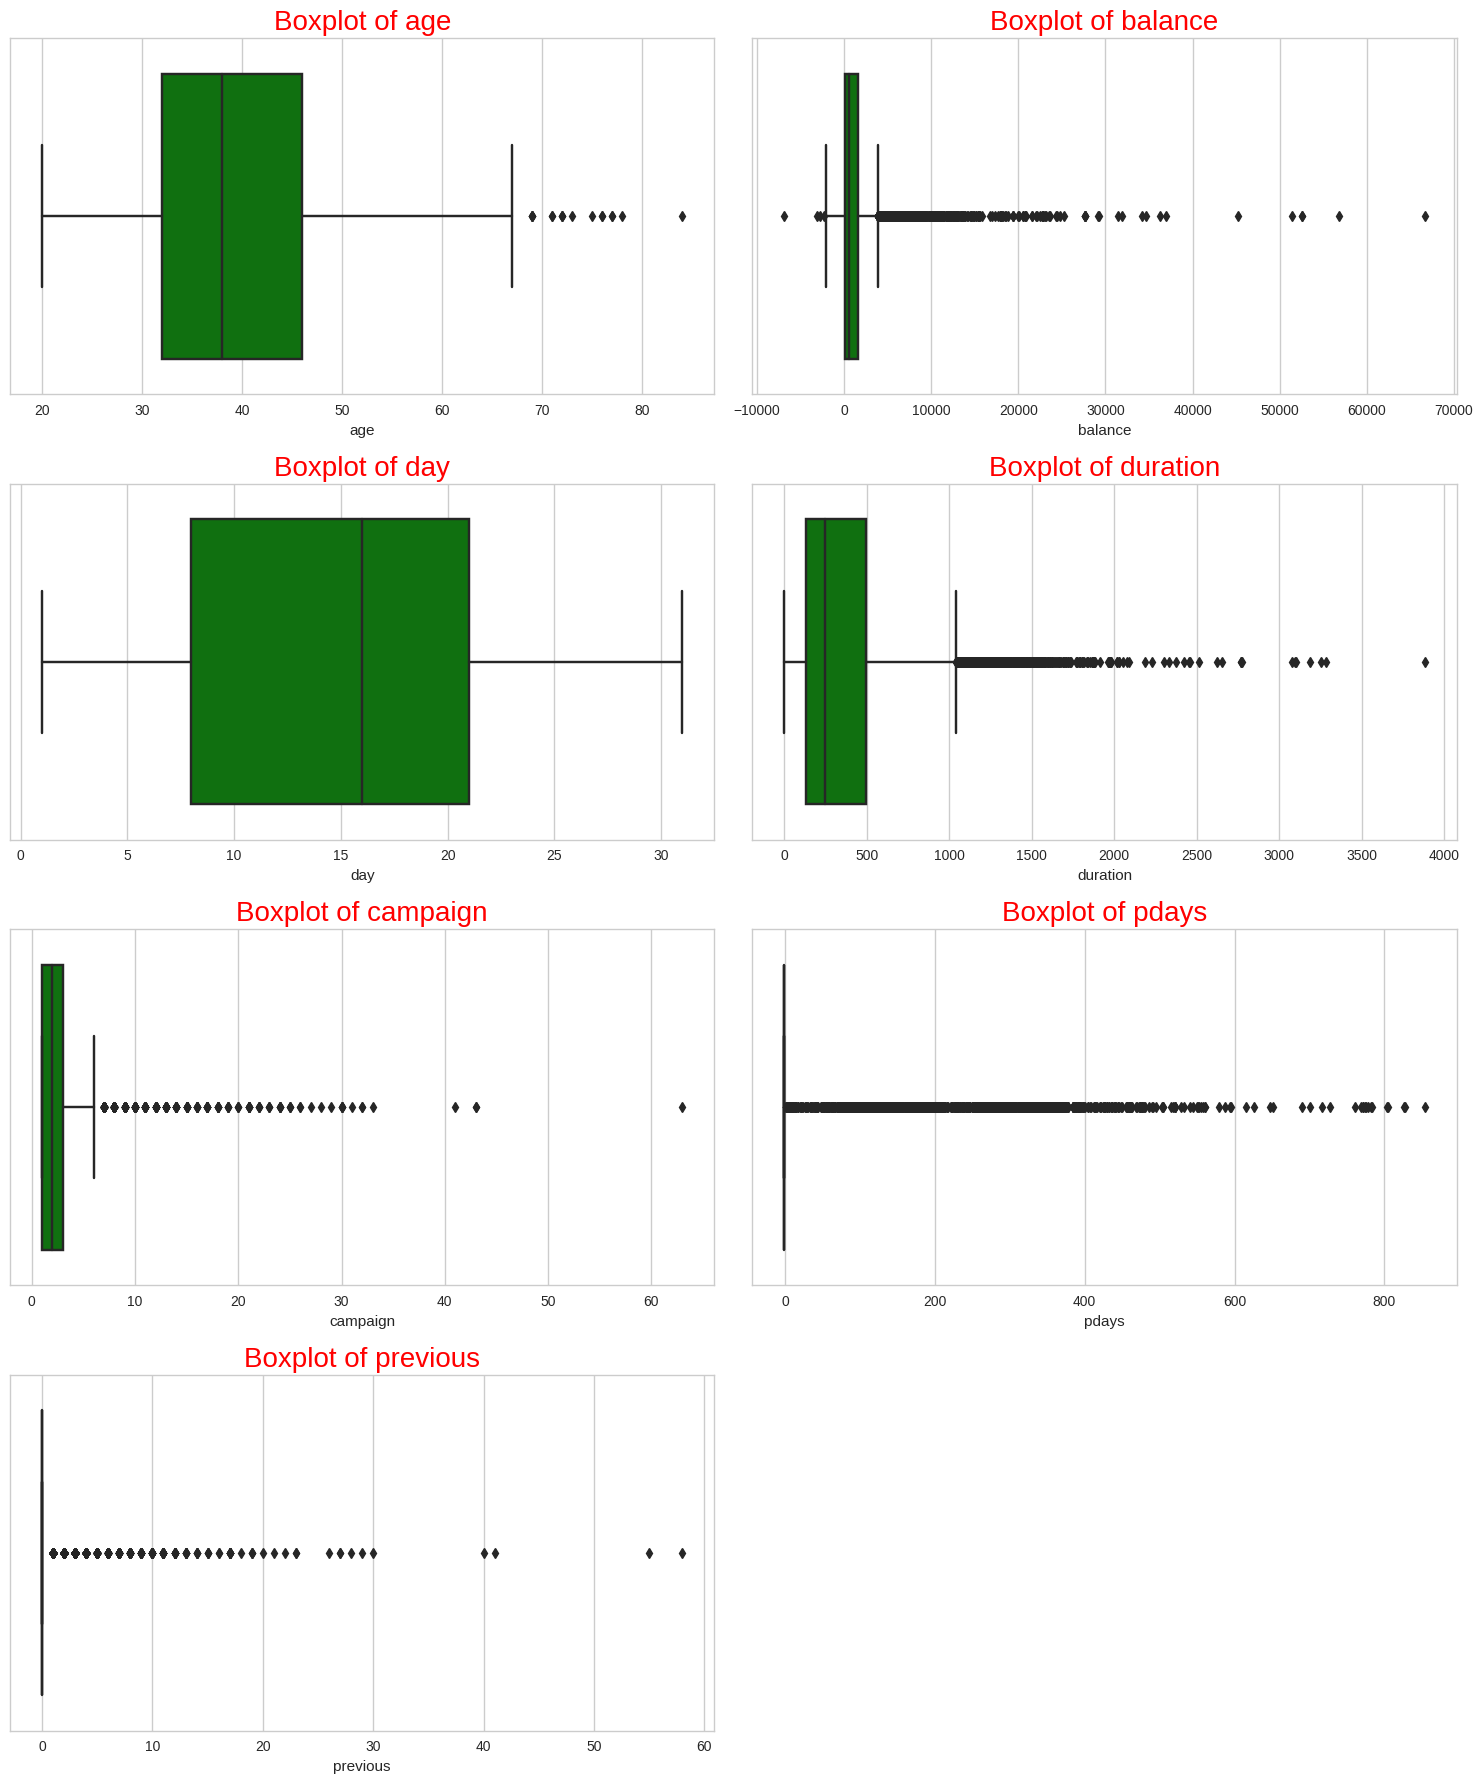

In [223]:
# 이상치 파악 => 무지성으로 지우는건 아님. 분석을 통한 판단으로 지워야 하는데.. kmeans는 이상치 영향 많이 받긴한다
plt.figure(figsize=(15,18))
for i, col in enumerate(con_feat) :
    plt.subplot(4,2,i+1)
    sns.boxplot(x=col, data=df[con_feat], color='green')
    plt.title(f"Boxplot of {col}",size=20,color="red")
plt.tight_layout()
plt.show()

In [224]:
def compare_boxplot(col):
    fig=px.box(df,x='pension',y=col,color='pension',template='simple_white',color_discrete_sequence=['YellowGreen','LightCoral'],title=f'<b>Effect of {col} on Pension Status')
    fig.update_layout(title_x=0.5,font_family="Times New Roman",legend_title_text="<b>Pension")
    fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

In [225]:
for feat in con_feat :
    compare_boxplot(feat)

> - 위 결과에 따라서 각 변수가 pension에 영향을 주는게 차이가 없는 것으로 판단되어 이상치 제거를 해도 될 것으로 결정.
> - 데이터셋 변경 후 이거는 좀 다시 손봐야 될 듯

In [226]:
# 이상치 제거 : IQR
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

Outliers_to_drop = detect_outliers(df, 2, con_feat)

In [227]:
df.loc[Outliers_to_drop]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pension
2351,72,self-employed,married,tertiary,no,132,no,no,App,1,jul,260,2,65,1,success,no
2820,77,management,married,unknown,no,1780,yes,no,App,23,oct,221,2,183,3,success,no
3446,77,management,married,unknown,no,1780,yes,no,App,23,apr,361,2,182,5,success,no
3461,76,self-employed,married,unknown,no,4984,no,no,call center,28,apr,403,1,182,1,success,no
3791,69,technician,married,tertiary,no,482,no,no,App,29,jul,478,1,267,1,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,35,management,married,secondary,no,725,yes,no,App,20,nov,219,7,133,1,failure,no
10573,44,management,single,secondary,no,985,yes,yes,App,11,may,9,7,325,19,failure,no
10765,37,management,married,tertiary,no,26,no,no,App,17,jun,151,7,62,4,failure,no
10938,53,blue-collar,single,secondary,no,1442,no,no,call center,9,dec,137,8,188,2,leave,no


In [228]:
# 355개 제거

df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pension
0,59,management,married,secondary,no,2343,yes,no,branch,5,may,1042,1,-1,0,unknown,no
1,56,management,married,secondary,no,45,no,no,branch,5,may,1467,1,-1,0,unknown,no
2,41,technician,married,secondary,no,1270,yes,no,branch,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,branch,5,may,579,1,-1,0,unknown,no
4,54,management,married,tertiary,no,184,no,no,branch,5,may,673,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8963,33,blue-collar,single,primary,no,1,yes,no,App,20,apr,257,1,-1,0,unknown,no
8964,39,services,married,secondary,no,733,no,no,branch,16,jun,83,4,-1,0,unknown,yes
8965,32,technician,single,secondary,no,29,no,no,App,19,aug,156,2,-1,0,unknown,no
8966,43,technician,married,secondary,no,0,no,yes,App,8,may,9,2,172,5,failure,yes


In [229]:
'''Skewness(비대칭도)란 분포가 얼마나 비대칭을 띄는가 알려주는 척도입니다.
(비대칭도: a=0이면 정규분포, a<0 이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침)
Kurtosis (첨도)란 확률분포의 뾰족한 정도를 나타내는 척도입니다.
관측치들이 어느 정도 집중적으로 중심에 몰려 있는가를 측정할 때 사용됩니다.'''

for col in con_feat :
  print('{:15}'.format(col), 'Skewness : {:05.2f}'.format(df[col].skew()), '    ', 'Kurtosis:{:05.2f}'.format(df[col].kurt()))

age             Skewness : 00.52      Kurtosis:-0.52
balance         Skewness : 08.07      Kurtosis:116.54
day             Skewness : 00.10      Kurtosis:-1.05
duration        Skewness : 02.23      Kurtosis:08.29
campaign        Skewness : 05.62      Kurtosis:57.37
pdays           Skewness : 02.70      Kurtosis:08.23
previous        Skewness : 08.31      Kurtosis:144.24


## 군집화

### 인코딩

In [230]:
cate_feat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'pension']

In [231]:
# 값 특성 상 데이터간 관계가 없으므로 LabelEncoder가 아닌 OH이용
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
df_encoded = pd.get_dummies(df, columns=cate_feat ,dummy_na=True)
df_encoded

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_management,...,month_sep,month_nan,poutcome_failure,poutcome_leave,poutcome_success,poutcome_unknown,poutcome_nan,pension_no,pension_yes,pension_nan
0,59,2343,5,1042,1,-1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,56,45,5,1467,1,-1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
2,41,1270,5,1389,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,55,2476,5,579,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,54,184,5,673,2,-1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8963,33,1,20,257,1,-1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
8964,39,733,16,83,4,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
8965,32,29,19,156,2,-1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8966,43,0,8,9,2,172,5,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### 정규화
- 변수별 값 범위가 다르므로

In [232]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded_sc = scaler.fit_transform(df_encoded)

### 차원축소
- 모델에 넣기 전 현재 피쳐의 수가 꽤 많은편입니다 수가 많을수록 모델이 성능이 내기 어려워집니다

In [233]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(df_encoded_sc)
df_for_clustering = pd.DataFrame(pca.transform(df_encoded_sc), columns=(["col1","col2", "col3"]))
df_for_clustering.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,8968.0,6.972319e-17,1.978842,-4.809676,-1.493411,-0.012154,1.285152,9.889135
col2,8968.0,-1.671772e-16,1.771383,-4.602056,-1.370689,-0.052488,1.174275,11.487051
col3,8968.0,-6.655396e-17,1.539267,-3.748615,-1.038194,-0.153227,0.863015,7.758088


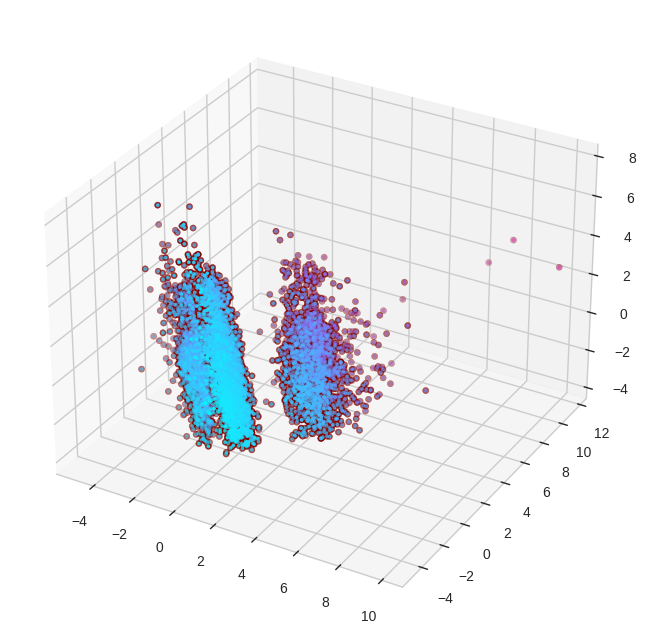

In [234]:
#A 3D Projection Of Data In The Reduced Dimension
x = df_for_clustering["col1"]
y = df_for_clustering["col2"]
z = df_for_clustering["col3"]
#To plot
from matplotlib import cm
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
p3d = ax.scatter(x, y, z, s=5, c=y, cmap = cm.cool)
plt.show()

### 군집 수 정하기
- 위에서의 전처리 과정 (이상치 제거, 범주형 데이터 처리, 정규화, 차원축소) 을 거쳐 군집화 단계를 진행합니다
- KMeans 기반 모델에서는 군집 수 (K) 선정의 이슈가 있습니다. 이를 Elbow Method, Silhouette Score 등을 통해 최적 K를 산정하기로 합니다
- 기존 KMeans에서 단점을 보완한 K-Means ++ 모델을 사용합니다

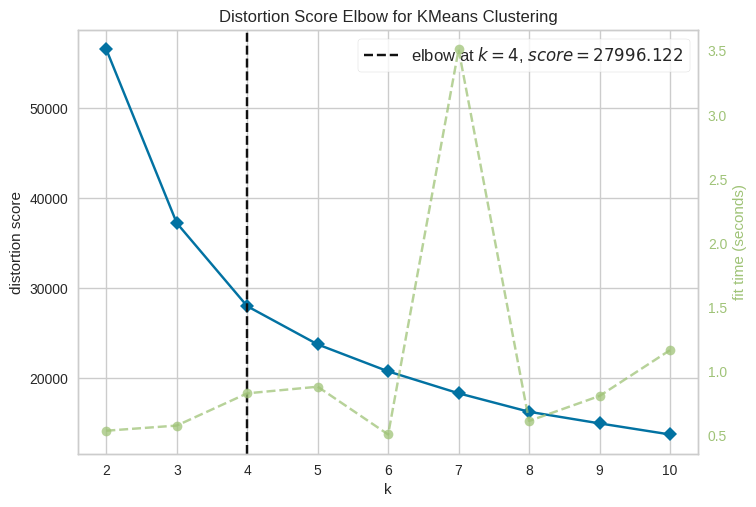

In [235]:
from yellowbrick.cluster import KElbowVisualizer

def plot_Elbow(df):
    Elbow_M = KElbowVisualizer(KMeans(), k=10)
    Elbow_M.fit(df)
    Elbow_M.show()
    optimal_K = Elbow_M.elbow_value_
    return optimal_K

optimal_K = plot_Elbow(df_for_clustering)
print(f'optimal_K : {optimal_K}')

- 위와 같이 비교적 구현하기 쉬운 Elbow Method를 통해 K 값을 구할 수도 있지만,
- 비교적 시간이 걸리더라도 보다 정확한 결과를 얻기위해 Silhouette score를 활용한 방식을 채택하였습니다

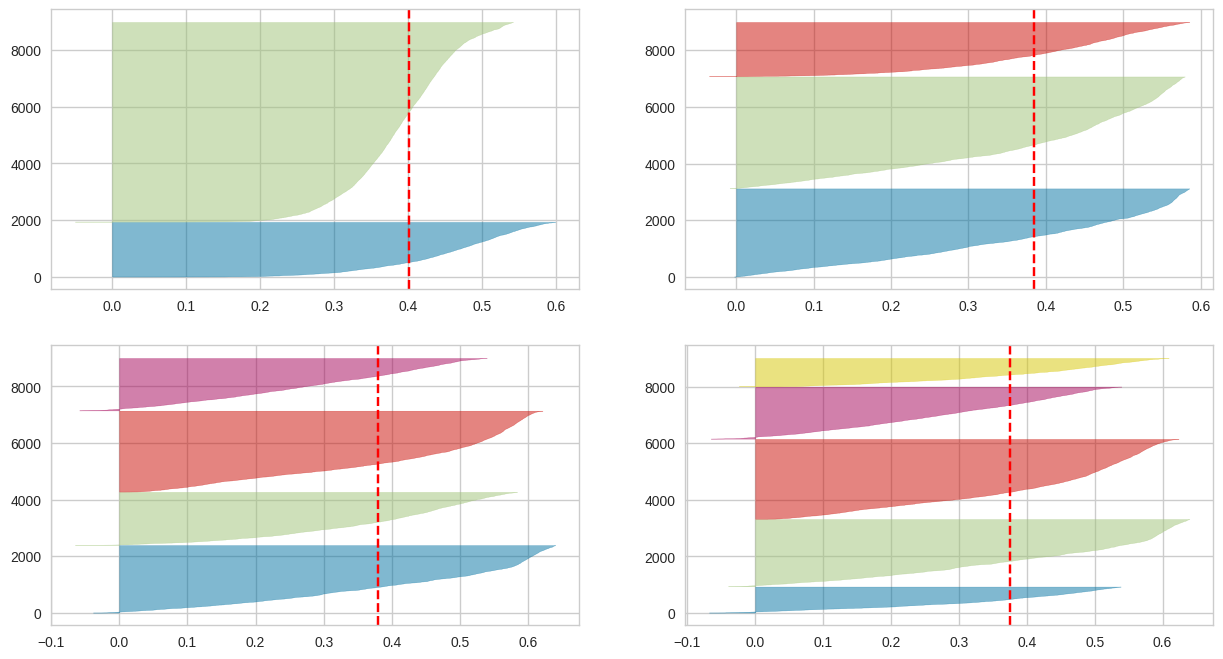

In [236]:
from yellowbrick.cluster import SilhouetteVisualizer

def plot_Silhouette(df):

    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in range(2,6) :
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42) # n_cluster가 아니라 n_cluster임
        q, mod = divmod(i, 2)
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(df)

plot_Silhouette(df_for_clustering)

> - 각 군집의 실루엣 점수가 평균을 넘으면서 , 두께가 서로 유사한 경우를 K 값으로 채택하였습니다
> - 위의 기준과 동시에 전체 평균값이 1에 가까울수록 최적 K 값으로 결정하였습니다

In [237]:
random_state = 15

# 위에서 구한 k를 바탕으로 기존 데이터프레임에 군집값을 넣음
def clustering(optimal_k, df_for_clustering, df_origin):
    km = KMeans(n_clusters=optimal_k, init='k-means++', random_state=random_state).fit(df_for_clustering)
    yhat_cluster = km.predict(df_for_clustering)
    df_for_clustering['cluster'] = yhat_cluster
    df_origin['cluster'] = yhat_cluster + 1

clustering(optimal_K, df_for_clustering, df)

In [238]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pension,cluster
0,59,management,married,secondary,no,2343,yes,no,branch,5,may,1042,1,-1,0,unknown,no,2
1,56,management,married,secondary,no,45,no,no,branch,5,may,1467,1,-1,0,unknown,no,2
2,41,technician,married,secondary,no,1270,yes,no,branch,5,may,1389,1,-1,0,unknown,yes,2
3,55,services,married,secondary,no,2476,yes,no,branch,5,may,579,1,-1,0,unknown,no,2
4,54,management,married,tertiary,no,184,no,no,branch,5,may,673,2,-1,0,unknown,no,3


### 군집화 결과

#### pca 결과

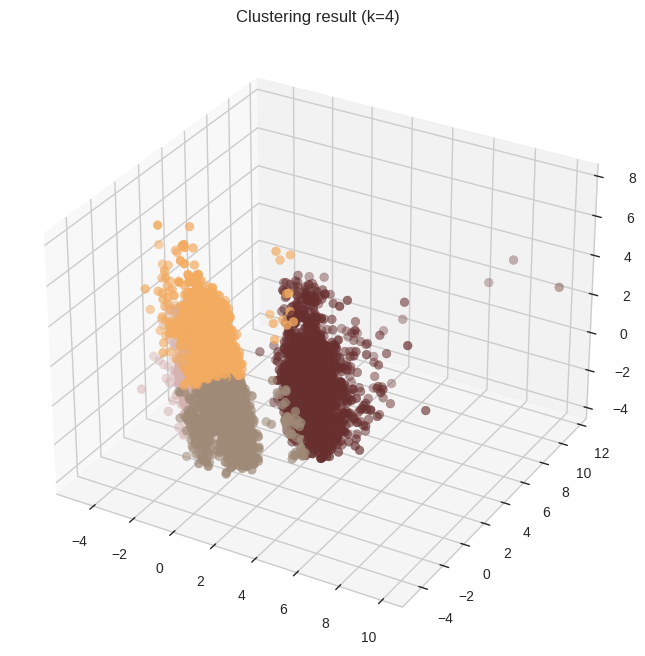

In [239]:
from matplotlib import colors

pal = ["#d7191c","#fdae61", "#abdda4", "#2b83ba"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# 군집결과 확인하기 (1) : pca 결과 확인
def distribution_cluster_pca(df_for_cluster, optimal_K) :
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(111, projection='3d', label="bla")
    x = df_for_cluster["col1"]
    y = df_for_cluster["col2"]
    z = df_for_cluster["col3"]
    ax.scatter(x, y, z, s=40, c=df_for_cluster["cluster"], marker='o', cmap = cmap )
    ax.set_title(f"Clustering result (k={optimal_K})")
    plt.show()

distribution_cluster_pca(df_for_clustering, optimal_K)

#### 군집 별 분석

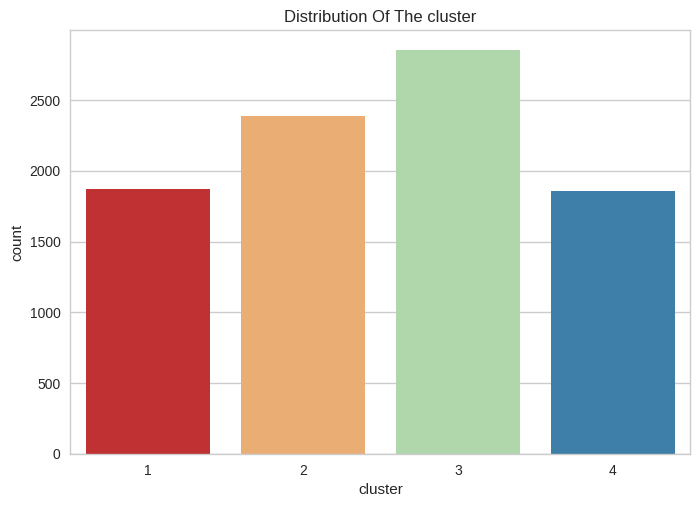

In [240]:
# 군집결과 확인하기 (2) : 기존 데이터프레임에서의 군집 분포 확인
def show_distribution_cluster(df) :
    pl = sns.countplot(x=df["cluster"], palette= pal)
    pl.set_title("Distribution Of The cluster")
    plt.show()

show_distribution_cluster(df)

> 군집별로 어디에 치중되지 않고 고루 나옴

In [267]:
cate_feat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'pension']

In [285]:
def plot_catefeats_by_cluster(df, optimal_K, feature_list, target): # 범주형 분석

  fig, axes = plt.subplots(nrows=optimal_K, ncols=len(feature_list),figsize=(50, 10))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)

  for cluster_num in range(1, optimal_K+1): # 1번군집부터 마지막 군집까지 군집별로 그림을 그려준다
    for idx, feature in enumerate(feature_list):
        if feature != target :
            plot = sns.countplot(x=feature, data=df.loc[df['cluster'] == cluster_num],
                                order = df.loc[df['cluster'] == cluster_num][feature].value_counts().iloc[:5].index[::-1], ax=axes[cluster_num-1, idx])
            if feature == 'job' : # rotate 필요한거에 한해서만
                plot.set_xticklabels(plot.get_xticklabels(), rotation=15)
            title = f'cluster_{cluster_num} "{feature}"'
            plot.set_title(title, fontsize=15, weight='bold')
            plot.set_xlabel(' ')
            plot.set_ylabel(' ')

        else :
            data = [df.loc[df['cluster'] == cluster_num]['pension'].value_counts()['yes'], df.loc[df['cluster'] == cluster_num]['pension'].value_counts()['no']]
            labels = ['Yes', 'No']
            explode = (0.1, 0)
            colors = sns.color_palette('pastel')[0:len(labels)]
            ax = axes[cluster_num-1, idx]
            ax.pie(data, explode=explode, labels = labels, autopct='%.0f%%', shadow = True, startangle = 90)
            ax.axis('equal')
            ax.set_title(f'cluster_{cluster_num} "{target}"')

  plt.show()

In [249]:
def plot_confeats_by_cluster(df, name_list): # 연속형 : 군집별 평균 값을 산출하는거라 군집 수를 받을 필요가 없음

  fig, axes = plt.subplots(1,len(name_list),figsize=(20, 5))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)

  for idx in range(len(name_list)):

    plot = sns.barplot(x=name_list[idx], y = 'cluster', data=df, orient='h', ci=None , ax=axes[idx])
    title = f'Average "{name_list[idx]}" by cluster'
    plot.set_title(title, fontsize=10, weight='bold')
    plot.set_xlabel(' ')
    plot.set_ylabel('cluster')

  plt.show()

- fig, axes = plt.subplots(optimal_K,len(feature_list),figsize=(50, 10))
    - 군집 수, 피쳐 수 만큼의 그래프를 먼저 그려주는 것임.
    - https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=heygun&logNo=221520454294

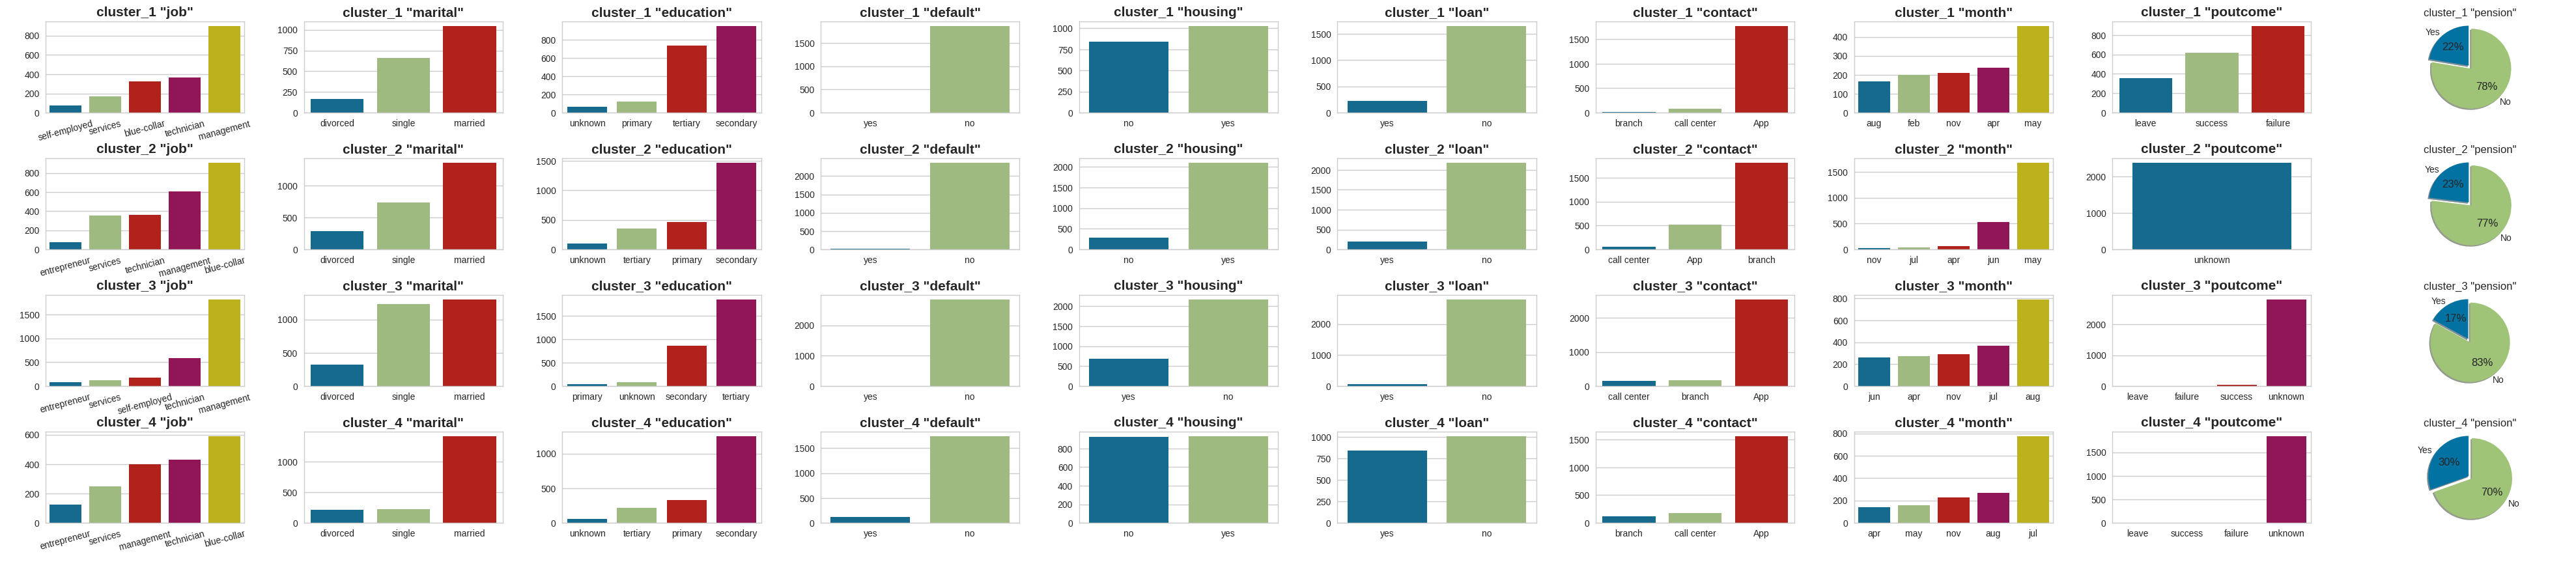

In [286]:
plot_catefeats_by_cluster(df, optimal_K, cate_feat, 'pension')

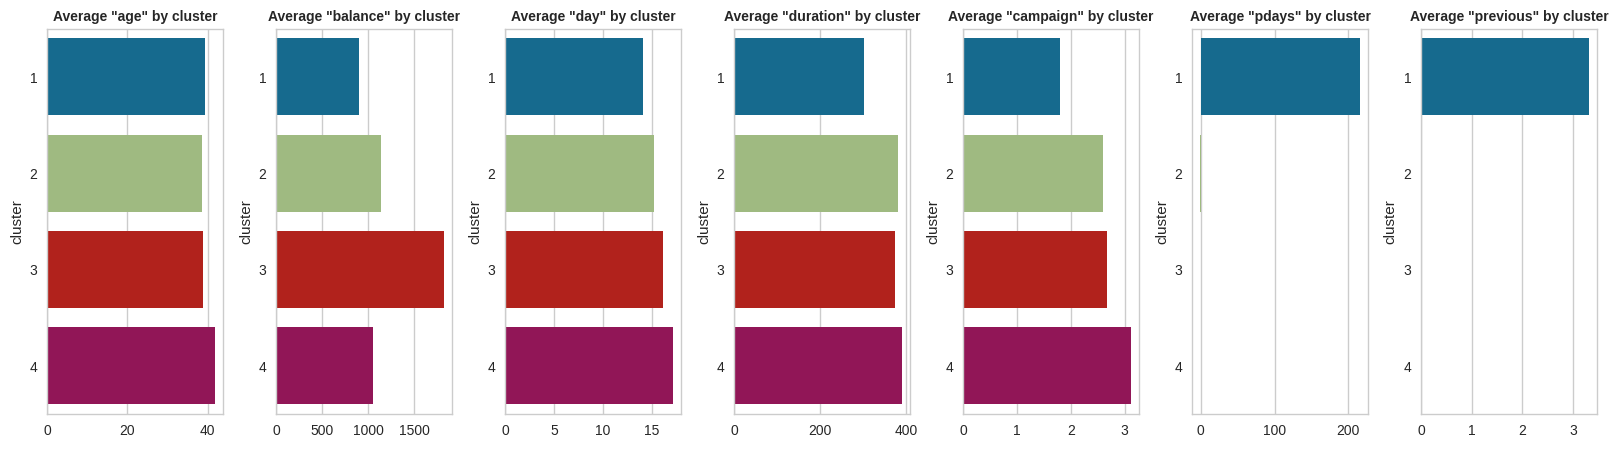

In [250]:
plot_confeats_by_cluster(df, con_feat)